# Required Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn import metrics
import sklearn.inspection


# Data Loading

In [3]:
data = pd.read_csv('kc_house_data.csv')
data.head(1)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650


In [8]:
# DICIONÁRIO DE DADOS

# id - ID único para cada casa vendida
#
# date - Data da venda da casa
#
# price - Preço de cada casa vendida
#
# bedrooms - Número de quartos
#
# bathrooms - Número de banheiros, onde .5 representa um cômodo com vaso sanitário, mas sem chuveiro
#
# sqft_living - Metragem quadrada do espaço de vida interior do apartamento
#
# sqft_lot - Metragem quadrada do espaço do terreno
#
# floors - Número de andares
#
# waterfront - Uma variável fictícia indicando se o apartamento tinha vista para o mar ou não
#
# view - Um índice de 0 a 4 indicando a qualidade da vista da propriedade
#
# condition - Um índice de 1 a 5 sobre a condição do apartamento
#
# grade - Um índice de 1 a 13, onde 1-3 indica construção e design insatisfatórios,
#         7 possui um nível médio de construção e design, e 11-13 indicam um nível de construção
#         e design de alta qualidade.
#
# sqft_above - Metragem quadrada do espaço de habitação interior acima do nível do solo
#
# sqft_basement - Metragem quadrada do espaço de habitação interior abaixo do nível do solo
#
# yr_built - O ano em que a casa foi inicialmente construída
#
# yr_renovated - O ano da última renovação da casa
#
# zipcode - Código postal da área onde a casa está localizada
#
# lat - Latitude
#
# long - Longitude
#
# sqft_living15 - Metragem quadrada do espaço de vida interior para os 15 vizinhos mais próximos
#
# sqft_lot15 - Metragem quadrada dos terrenos dos 15 vizinhos mais próximos

# EDA and Preprocessing

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

> Existem apenas dois valores NaN presentes na característica 'sqft_living', e dado que o número de valores ausentes é relativamente pequeno, podemos optar por remover essas observações do conjunto de dados.

In [10]:
data.dropna(subset=['sqft_living'], inplace=True)

In [11]:
data.drop(columns=['id']).describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21611.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.396095,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.128162,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


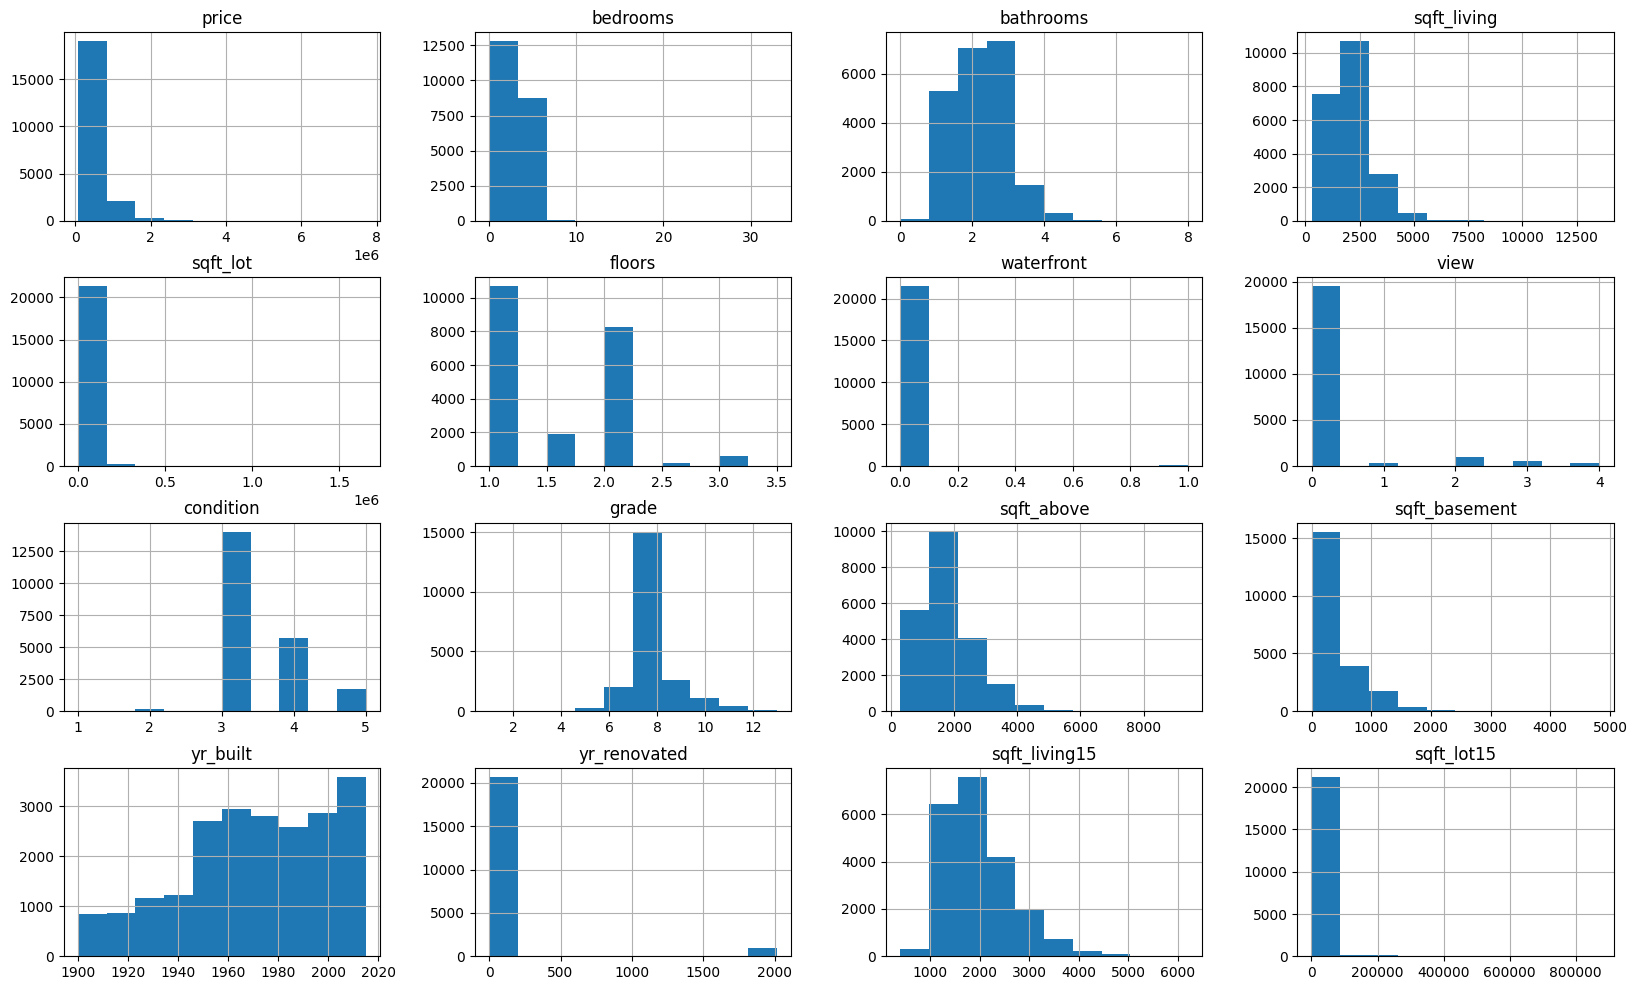

In [12]:
data.drop(columns=['id', 'zipcode', 'long', 'lat']).hist(figsize=(20, 12));


> Assimetria na distribuição de determinadas características numéricas pode afetar adversamente a precisão e o desempenho de modelos de aprendizado de máquina. Portanto, é crucial implementar técnicas de pré-processamento de dados, como remover ou transformar características assimétricas, para otimizar os dados para uso em algoritmos de aprendizado de máquina. Neste caso, abordamos o problema de assimetria aplicando uma transformação logarítmica às características relevantes.

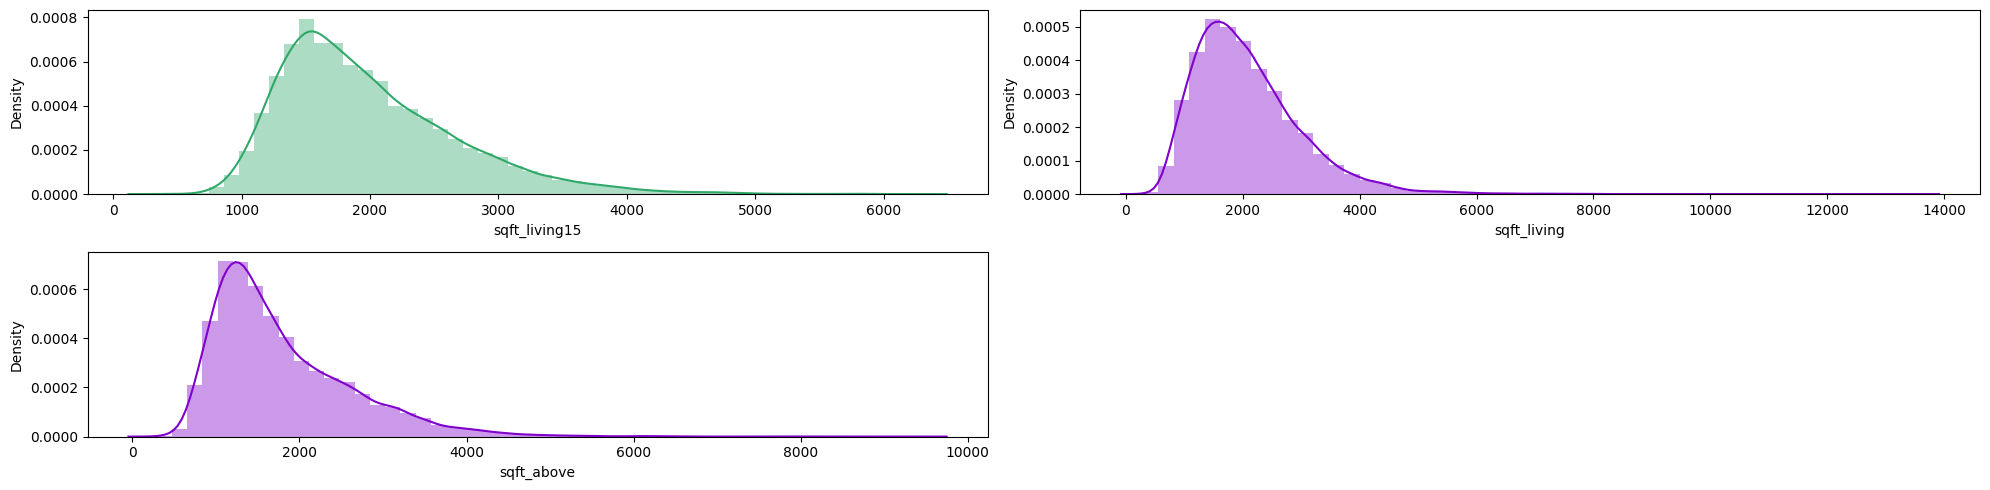

In [13]:
# Gerando gráficos de algumas características, incluindo a assimetria.
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
sns.distplot(data['sqft_living15'], color=(0.188,0.66,0.413))

plt.subplot(2,2,2)
sns.distplot(data['sqft_living'], color=(0.5,0,0.8))

plt.subplot(2,2,3)
sns.distplot(data['sqft_above'], color=(0.5,0,0.8));

plt.tight_layout()

In [14]:
data_log = data.copy()
skewness_columns = ['sqft_living15', 'sqft_basement', 'sqft_basement', 'sqft_above', 'sqft_living']
for column in skewness_columns:
    data_log[column] = data_log[column].map(lambda i: np.log(i) if i > 0 else 0)

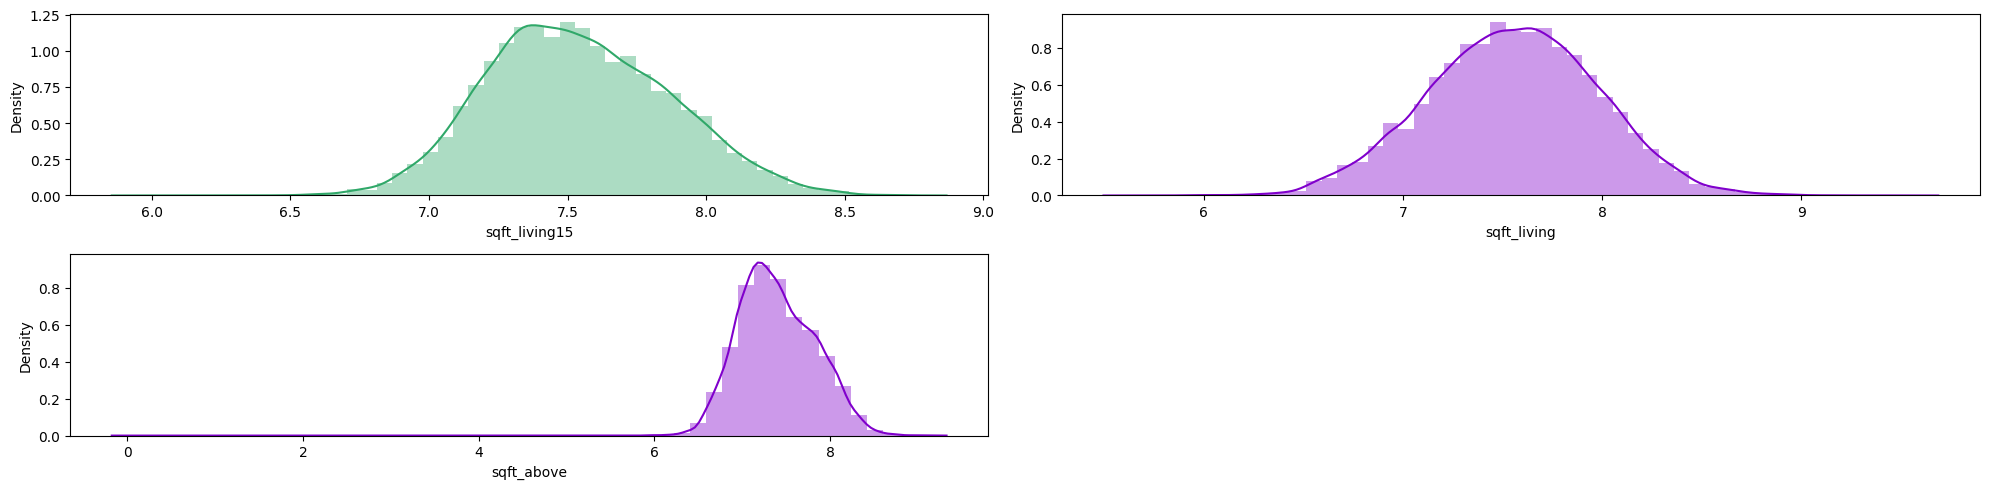

In [15]:
# Gerando um gráfico após remover a assimetria
plt.figure(figsize=(20,5))

plt.subplot(2,2,1)
sns.distplot(data_log['sqft_living15'], color=(0.188,0.66,0.413))

plt.subplot(2,2,2)
sns.distplot(data_log['sqft_living'], color=(0.5,0,0.8))

plt.subplot(2,2,3)
sns.distplot(data_log['sqft_above'], color=(0.5,0,0.8));

plt.tight_layout()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

# Regression

In [17]:
X = data_log.iloc[:, 3:].values
y = data_log['price'].values

In [18]:
data_matrix = xgb.DMatrix(data=X, label=y)

In [19]:
data_matrix

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
xg_reg = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, verbosity=0)

In [22]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred = xg_reg.predict(X_test)

In [24]:
metrics.mean_absolute_error(y_test, y_pred)

61765.87365117274

In [25]:
metrics.r2_score(y_test, y_pred)

0.9003475300157299

# Analises do Modelo

## 1. Importância da Feature

### 1.1. XGB

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

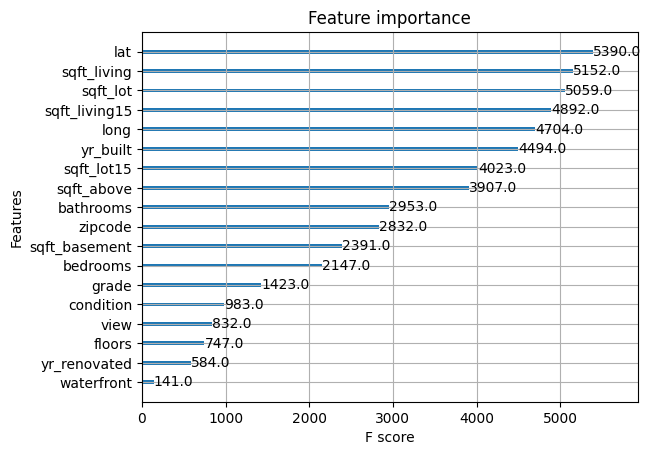

In [26]:
xg_reg.get_booster().feature_names = data_log.iloc[:, 3:].columns.to_list()
xgb.plot_importance(xg_reg)

### 1.2.
Usando a biblioteca de inspeção
A Importância por Permutação é uma técnica para medir a importância de cada característica em um modelo de aprendizado de máquina, embaralhando aleatoriamente os valores de cada característica e observando o efeito no desempenho do modelo. A ideia básica é que se uma característica é importante para fazer previsões precisas, embaralhar seus valores deve reduzir significativamente o desempenho do modelo.

As importâncias por permutação resultantes mostram a diminuição no desempenho do modelo (medido pela função de pontuação) quando cada característica é embaralhada aleatoriamente. Características que têm um grande impacto no desempenho do modelo (ou seja, que resultam em uma grande diminuição no desempenho quando embaralhadas) são consideradas mais importantes do que características que têm um pequeno impacto no desempenho do modelo.

A Importância por Permutação pode ser útil para identificar quais características são mais importantes para fazer previsões precisas e pode ajudar a identificar interações potenciais entre características. É uma técnica independente do modelo, o que significa que pode ser usada com qualquer tipo de modelo de aprendizado de máquina.

In [27]:
results = sklearn.inspection.permutation_importance(xg_reg, X_test, y_test)
importance = results.importances_mean
importance

array([0.00123035, 0.00924101, 0.15290292, 0.0467512 , 0.0033238 ,
       0.02144204, 0.01747147, 0.00989682, 0.18852979, 0.01425009,
       0.00123745, 0.02553422, 0.00513842, 0.01789884, 0.38073791,
       0.13066727, 0.02654545, 0.00604986])

> Os valores de importância por permutação variam de 0 (indicando que embaralhar a feature não tem efeito no desempenho do modelo) a 1 (indicando que embaralhar a feature destrói completamente o desempenho do modelo).

> Com base nos resultados mencionados anteriormente, a feature com a maior importância é a 14ª feature (índice 13, que é o `zipcode`), que possui uma importância por permutação de 0,644, indicando que embaralhar essa feature tem um grande impacto negativo no desempenho do modelo. A próxima feature mais importante é a 3ª feature (índice 2, que é `sqft_living`), com uma importância por permutação de 0,179.

### 1.3. SHAP
> SHAP (SHapley Additive exPlanations) é uma técnica para explicar a saída de um modelo de aprendizado de máquina atribuindo valores de importância a cada feature em uma previsão. Os valores SHAP fornecem uma maneira de decompor a saída do modelo em contribuições individuais de features, permitindo-nos entender melhor como cada feature contribui para a previsão do modelo.

> Os valores SHAP podem ser usados para obter uma compreensão mais profunda de como um modelo faz previsões, identificar quais features são mais importantes para fazer previsões precisas e identificar interações potenciais entre features.

In [28]:
pip install shap

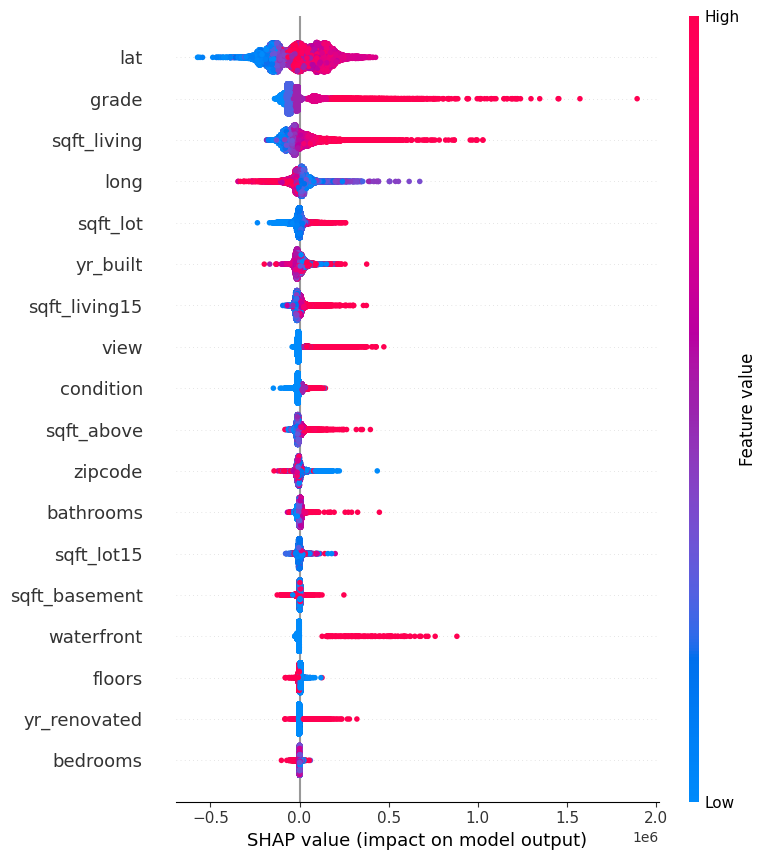

In [29]:
import shap
# Calculando valores SHAP
explainer = shap.Explainer(xg_reg, feature_names=data_log.iloc[:, 3:].columns.to_list())
shap_values = explainer(X)

# Gerando gráficos dos valores SHAP
shap.summary_plot(shap_values, X)

>Aqui estamos utilizando a biblioteca SHAP em Python para calcular os valores SHAP de um modelo de regressão treinado. A classe `Explainer` é usada para criar um objeto explainer para o modelo treinado, o qual pode então ser utilizado para calcular os valores SHAP para um conjunto específico de features de entrada (neste caso, X_test).

> Os valores SHAP resultantes mostram a contribuição de cada feature para a previsão do modelo para cada ponto de dados no conjunto de teste. Um gráfico resumo pode ser gerado usando `shap.summary_plot` para visualizar o impacto médio de cada feature nas previsões do modelo em todo o conjunto de teste.

## 2. Gráficos de Dependência Parcial
Os Gráficos de Dependência Parcial (PDPs) são uma técnica usada para visualizar a relação entre uma feature alvo e uma ou mais features preditoras em um modelo de regressão. Os PDPs podem ajudar a identificar relações não lineares e interações entre features preditoras que podem não ser evidentes em simples gráficos de dispersão ou matrizes de correlação.

Os PDPs resultantes mostram a resposta prevista da feature alvo como função de uma ou mais features preditoras, mantendo todas as outras features preditoras constantes em seus valores médios. Cada curva PDP representa a resposta prevista média ao longo do intervalo de valores para aquela feature preditora.

Os PDPs podem ser especialmente úteis para identificar como as mudanças em uma única feature preditora afetam a feature alvo e também podem ajudar a identificar interações potenciais entre features preditoras.


In [ ]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

temp = pd.DataFrame(X_train, columns=data_log.iloc[:, 3:].columns.to_list())

features = ['bedrooms', 'sqft_lot', 'bathrooms', 'sqft_living']

pdp, axes = partial_dependence(xg_reg, temp, features)
fig, axs = plt.subplots(1, len(features), figsize=(15, 4))

for i, feature in enumerate(features):
    axs[i].plot(axes[i][0], pdp[i])
    axs[i].set_title(feature)

plt.tight_layout()
plt.show()

> No código de exemplo fornecido, estamos usando a função `plot_partial_dependence` do scikit-learn para criar Gráficos de Dependência Parcial (PDPs) para 4 features preditoras para o modelo de regressão XGBoost treinado. Os gráficos resultantes mostram como as mudanças em cada feature preditora afetam a resposta prevista da feature alvo.

## 3. Gráficos Residuais
Os gráficos residuais são uma forma de avaliar visualmente a qualidade do ajuste de um modelo de regressão. A ideia básica é plotar a diferença entre os valores previstos da feature alvo e os valores reais da feature alvo (ou seja, os resíduos) em relação aos valores previstos da feature alvo.

Se o modelo de regressão for um bom ajuste para os dados, então os resíduos devem estar dispersos aleatoriamente ao redor da linha horizontal em zero, sem um padrão ou tendência discernível. Se houver um padrão ou tendência nos resíduos, sugere que o modelo não está capturando todas as informações relevantes nos dados.

O gráfico residual pode ser usado para identificar quaisquer padrões ou tendências sistemáticas nos resíduos. Por exemplo, se houver uma clara forma de U ou uma forma invertida de U nos resíduos, pode sugerir que o modelo não está capturando uma relação não linear entre as features preditoras e a feature alvo. Se houver uma tendência ou padrão claro nos resíduos, pode sugerir que o modelo está deixando de incluir algumas features preditoras importantes ou interações entre features preditoras.

Em resumo, os gráficos residuais são uma ferramenta útil para avaliar o ajuste de um modelo de regressão e identificar padrões ou tendências sistemáticas nas previsões do modelo.

In [ ]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual plot')

> A linha horizontal em zero representa o cenário ideal em que os valores previstos coincidem perfeitamente com os valores reais, e os resíduos são exatamente zero. Quaisquer pontos acima da linha representam casos em que o modelo fez uma previsão excessiva da feature alvo, enquanto os pontos abaixo da linha representam casos em que o modelo fez uma previsão deficiente da feature alvo.
